We load our cleaned dataset.

In [1]:
from fastai.tabular.all import *

comp = 'bluebook-for-bulldozers'
path = URLs.path(comp)

xs_final = load_pickle(path/'xs_final.pkl')
valid_xs_final = load_pickle(path/'valid_xs_final.pkl')
y_final = load_pickle(path/'y_final.pkl')
valid_y_final = load_pickle(path/'valid_y_final.pkl')
to = load_pickle(path/'to.pkl')
dep_var = 'SalePrice'

In [2]:
from sklearn.ensemble import RandomForestRegressor

def rf(xs, y, n_estimators=40, max_samples=200_000,
       max_features=0.5, min_samples_leaf=5, **kwargs):
    return RandomForestRegressor(n_jobs=-1, n_estimators=n_estimators,
        max_samples=max_samples, max_features=max_features,
        min_samples_leaf=min_samples_leaf, oob_score=True).fit(xs, y)


The most significant factors are `ProductSize` and `YearMade`. Aiming to understand their relationship with `saleprice`, we first check the count of valuer per category.

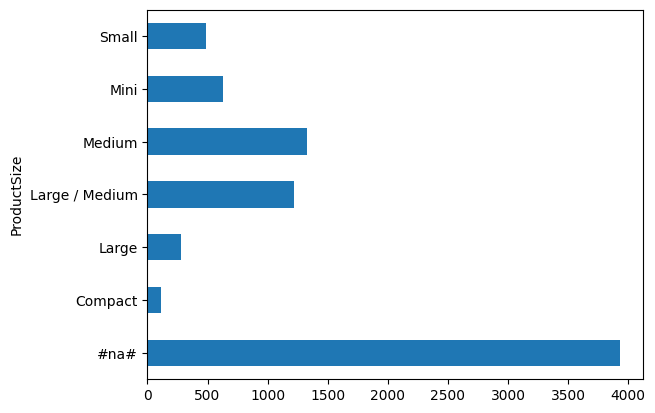

In [3]:
import matplotlib.pyplot as plt

p = valid_xs_final['ProductSize'].value_counts(sort=False).sort_index().plot.barh()
c = to.classes['ProductSize']
plt.yticks(range(len(c)), c);


Note that the plot in the book is wrong since it was generated without `sort_index()`, so the ordering of the bars was arbitrary and they are mislabelled.

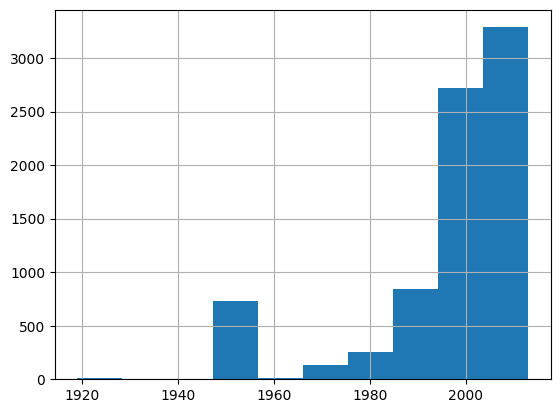

In [4]:
valid_xs_final.loc[valid_xs_final['YearMade'] < 1900, 'YearMade'] = 1950
ax = valid_xs_final['YearMade'].hist()

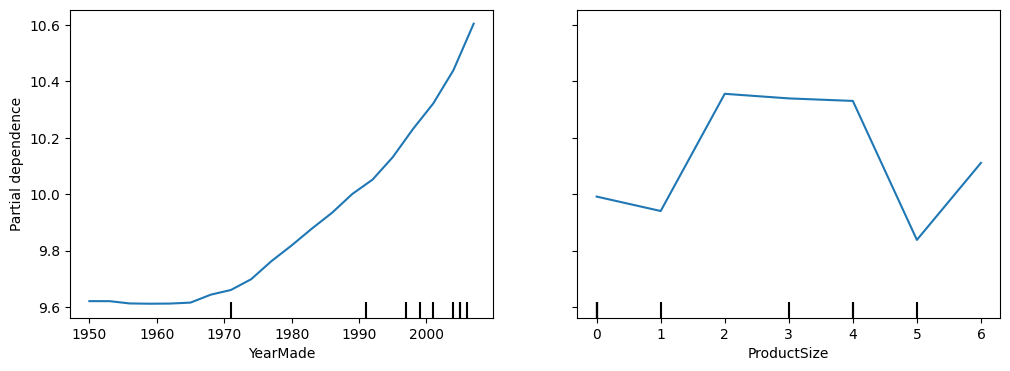

In [5]:
from sklearn.inspection import PartialDependenceDisplay

m = rf(xs_final, y_final)
fig, ax = plt.subplots(figsize=(12, 4))
PartialDependenceDisplay.from_estimator(m, valid_xs_final, ['YearMade','ProductSize'],
                        grid_resolution=20, ax=ax);


Here we see that `YearMade` has a clear relation with `saleprice`. `ProductSize` seems to be bimodal between smallish cars and regular/large cars. Many rows have missing values for `ProductSize`, but the non-presence so far seems like it is perhaps independent.

Finally, we discuss plotting the contributions each feature lends to the predictions, for a single row.

In [6]:
from treeinterpreter import treeinterpreter
from waterfall_chart import plot as waterfall

row = valid_xs_final.iloc[:5]
prediction, bias, contributions = treeinterpreter.predict(m, row.values)
prediction[0], bias[0], contributions[0].sum()

(array([9.72072537]),
 np.float64(10.104704788656477),
 np.float64(-0.38397941765640736))

/home/jhanschoo/.local/share/hatch/env/virtual/fai/Rcp_9cR7/fastbook/lib/python3.12/site-packages/waterfall_chart.py:141: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y = y_height[loop] + row['amount']
/home/jhanschoo/.local/share/hatch/env/virtual/fai/Rcp_9cR7/fastbook/lib/python3.12/site-packages/waterfall_chart.py:139: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y = y_height[loop]


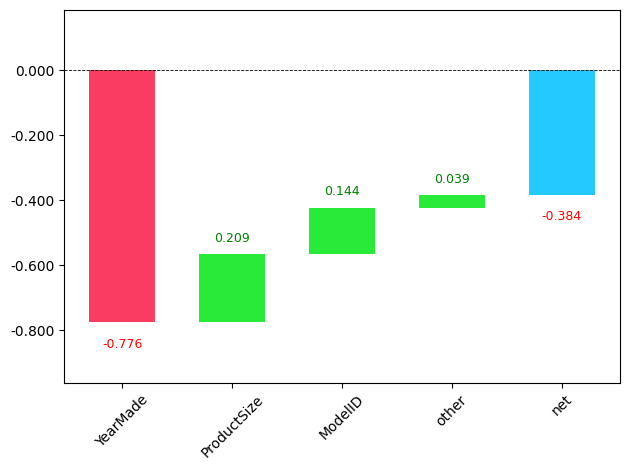

In [7]:
waterfall(valid_xs_final.columns, contributions[0], threshold=0.08, 
          rotation_value=45,formatting='{:,.3f}');